In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
df_data = pd.read_csv('./Data/data_processed.csv').dropna()
le = preprocessing.LabelEncoder()
df_data['class'] = le.fit_transform(df_data.genre)
df_data

,title,genre,summary,clean_text,clean_title,class
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,drown wednesday first trustee among morrow day...,drown wednesday,1
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",book open jason awakens school bus unable reme...,lose hero,1
2,Thendara House,fantasy,The novel concerns the dwelling of the Darkov...,novel concern dwell darkovan order renunciates...,thendara house,1
3,The Thief,fantasy,"Gen is released from prison by the magus, the...",gen release prison magus king scholar magus fi...,thief,1
4,The Sweet Far Thing,fantasy,The prologue begins with two men who are sear...,prologue begin two men search river london thr...,sweet far thing,1
...,...,...,...,...,...,...
2995,The Time Traveler's Wife,fantasy,This is the extraordinary love story of Clare ...,extraordinary love story clare henry meet clar...,time traveler wife,1
2996,Fantastic Beasts and Where to Find Them: The O...,fantasy,J.K. Rowling's screenwriting debut is captured...,j k rowling screenwriting debut capture exciti...,fantastic beast find original screenplay,1
2997,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,charlie bucket wonderful adventure begin find ...,charlie chocolate factory,1
2998,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...",rise love dimitri dimitri might love tasha mas...,frostbite,1


In [3]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, text, Y, transform = None):
        self.text = text
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.text[idx], self.Y[idx]
    

def str2idx(df, word2index, cut_length):
    idx_seq_li = []
    for i in range(len(df)):
        idx_li = []
        for w in word_tokenize(df.clean_text.iloc[i]):
            if word2index.get(w):
                idx = word2index[w]
            else:
                idx = word2index['UNK']
            idx_li.append(idx)

        if len(idx_li) >= cut_length:
            idx_li = idx_li[:cut_length]
        else:
            for i in range(cut_length - len(idx_li)):
                idx_li.append(0)
        idx_seq_li.append(idx_li)
    return np.array(idx_seq_li)


def generate_data_loader(df_data, batch_size, cut_length):
    
    X = np.arange(len(df_data))
    y = df_data['class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=23)

    data_train = df_data.iloc[X_train]
    data_test = df_data.iloc[X_test] 

    # word2index
    all_words = [i for w in list(data_train.clean_text) for i in word_tokenize(w)]
    unique_words = list(set(all_words))
    word2index = {w:i+1 for i,w in enumerate(unique_words)}
    word2index['PAD'] = 0
    word2index['UNK'] = len(word2index)

    train_arr = str2idx(data_train, word2index, cut_length)
    test_arr = str2idx(data_test, word2index, cut_length)

    train_data = TextDataset(torch.from_numpy(train_arr).long(), 
                         torch.from_numpy(y_train.to_numpy()).long())

    test_data = TextDataset(torch.from_numpy(test_arr).long(),
                        torch.from_numpy(y_test.to_numpy()).long())

    train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
    
    return data_train, data_test, train_loader, test_loader, word2index

In [4]:
class TextCNN(nn.ModuleList):

    def __init__(self, params):
        super(TextCNN, self).__init__()

        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = params.embedding_size

        # Dropout definition
        self.dropout = nn.Dropout(0.5)

        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5

        # Output size for each convolution
        self.out_size = params.out_size
        
        # Number of strides for each convolution
        self.stride = params.stride
        
        # Dense layers
        self.dense_out = params.dense_out
        self.class_num = params.class_num

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words, self.embedding_size, padding_idx=0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)

        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)

        # Fully connected layer definition
        self.fc1 = nn.Linear(self.in_features_fc(), self.dense_out)
        self.fc2 = nn.Linear(self.dense_out, self.class_num)
        
        
    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
    
    
    def forward(self, x):

        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)

        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)

        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)

        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        union = union.reshape(union.size(0), -1)

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc1(union)
        # Dropout is applied
        out = self.dropout(out)
        out = self.fc2(out)
        # Activation function is applied
        out = F.log_softmax(out, dim=1)

        return out

In [11]:
batch_size = 128
cut_length = 500
data_train, data_test, train_loader, test_loader, word2index = generate_data_loader(df_data, batch_size, cut_length)


@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = cut_length
    num_words: int = len(word2index)

    # Model parameters
    embedding_size: int = 100
    out_size: int = 64
    stride: int = 2
    class_num: int = len(le.classes_)
    dense_out: int =128
        
param = Parameters
lr = 0.001
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TextCNN(param).to(device)
print(model)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-8)

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # train
    train_epoch_loss = 0
    # set net to train mode
    model.train()
    train_preds = []
    
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        # pass the data into the network and store the output 
        y_train_pred = model(X_train)
        # Calculate the loss between the output and target 
        train_loss = criterion(y_train_pred, y_train)

        # Perform backpropagation 
        l2_lambda = 0.01
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        train_loss += l2_lambda * l2_reg
        
        train_loss.backward()
        optimizer.step()

        # Add the loss 
        train_epoch_loss +=  train_loss.item() 
        
        # Prediction
        train_preds += list(torch.argmax(y_train_pred, dim=1).cpu().detach().numpy())
        
    # validation 
    with torch.no_grad():
        val_preds = []
        val_epoch_loss = 0
        model.eval()
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)

            val_loss = criterion(y_val_pred, y_val)
            l2_lambda = 0.01
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            val_loss += l2_lambda * l2_reg
            val_epoch_loss +=  val_loss.item() 
            val_preds += list(torch.argmax(y_val_pred, dim=1).cpu().detach().numpy())
            
    # append average epoch loss to losses list  
    train_losses.append(train_epoch_loss/len(train_loader))
    val_losses.append(val_epoch_loss/len(test_loader)) 
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'\
      .format(epoch + 1, num_epochs,train_losses[-1],val_losses[-1]))
    print('train accuracy {} \t val accuracy {}'\
      .format(accuracy_score(data_train['class'], train_preds), 
              accuracy_score(data_test['class'], val_preds)))


TextCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(37949, 100, padding_idx=0)
  (conv_1): Conv1d(500, 64, kernel_size=(2,), stride=(2,))
  (conv_2): Conv1d(500, 64, kernel_size=(3,), stride=(2,))
  (conv_3): Conv1d(500, 64, kernel_size=(4,), stride=(2,))
  (conv_4): Conv1d(500, 64, kernel_size=(5,), stride=(2,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

 EPOCH 1/1000 	 train loss 22.24051909013228 	 val loss 21.40981928507487
train accuracy 0.16610925306577481 	 val accuracy 0.16666666666666666

 EPOCH 2/1000 	 train loss 20.99599049308


 EPOCH 54/1000 	 train loss 8.449050079692494 	 val loss 10.235044161478678
train accuracy 0.9899665551839465 	 val accuracy 0.38666666666666666

 EPOCH 55/1000 	 train loss 8.25872312892567 	 val loss 10.275072733561197
train accuracy 0.9918246005202527 	 val accuracy 0.35333333333333333

 EPOCH 56/1000 	 train loss 8.104702711105347 	 val loss 10.055598894755045
train accuracy 0.990709773318469 	 val accuracy 0.34

 EPOCH 57/1000 	 train loss 7.918220736763694 	 val loss 9.874881426493326
train accuracy 0.990709773318469 	 val accuracy 0.36

 EPOCH 58/1000 	 train loss 7.760289322246205 	 val loss 9.791688601175943
train accuracy 0.9910813823857302 	 val accuracy 0.36333333333333334

 EPOCH 59/1000 	 train loss 7.5790700695731426 	 val loss 9.540024439493815
train accuracy 0.9918246005202527 	 val accuracy 0.36

 EPOCH 60/1000 	 train loss 7.426887273788452 	 val loss 9.59855842590332
train accuracy 0.9914529914529915 	 val accuracy 0.3433333333333333

 EPOCH 61/1000 	 train loss 7.


 EPOCH 113/1000 	 train loss 3.5715221383354883 	 val loss 6.005336761474609
train accuracy 0.9910813823857302 	 val accuracy 0.47333333333333333

 EPOCH 114/1000 	 train loss 3.5355386950752954 	 val loss 5.873907725016276
train accuracy 0.9929394277220365 	 val accuracy 0.48333333333333334

 EPOCH 115/1000 	 train loss 3.498249140652743 	 val loss 5.896636962890625
train accuracy 0.9910813823857302 	 val accuracy 0.4666666666666667

 EPOCH 116/1000 	 train loss 3.4607515118338843 	 val loss 5.863053321838379
train accuracy 0.992196209587514 	 val accuracy 0.4633333333333333

 EPOCH 117/1000 	 train loss 3.4295109402049673 	 val loss 5.724290053049724
train accuracy 0.9918246005202527 	 val accuracy 0.4666666666666667

 EPOCH 118/1000 	 train loss 3.3987261165272105 	 val loss 5.656322320302327
train accuracy 0.9914529914529915 	 val accuracy 0.47

 EPOCH 119/1000 	 train loss 3.3617325696078213 	 val loss 5.678304036458333
train accuracy 0.9910813823857302 	 val accuracy 0.473333333


 EPOCH 172/1000 	 train loss 1.994170367717743 	 val loss 3.7852776845296225
train accuracy 0.9899665551839465 	 val accuracy 0.47

 EPOCH 173/1000 	 train loss 1.975553268736059 	 val loss 3.799332618713379
train accuracy 0.9903381642512077 	 val accuracy 0.4866666666666667

 EPOCH 174/1000 	 train loss 1.9534634080800144 	 val loss 3.7690930366516113
train accuracy 0.9899665551839465 	 val accuracy 0.4666666666666667

 EPOCH 175/1000 	 train loss 1.9294152639128945 	 val loss 3.7175021171569824
train accuracy 0.9903381642512077 	 val accuracy 0.4766666666666667

 EPOCH 176/1000 	 train loss 1.9120618321678855 	 val loss 3.684414863586426
train accuracy 0.9910813823857302 	 val accuracy 0.47333333333333333

 EPOCH 177/1000 	 train loss 1.8902147791602395 	 val loss 3.6767019430796304
train accuracy 0.9903381642512077 	 val accuracy 0.4633333333333333

 EPOCH 178/1000 	 train loss 1.8738427053798328 	 val loss 3.6728952725728354
train accuracy 0.9903381642512077 	 val accuracy 0.47666


 EPOCH 230/1000 	 train loss 1.0695044560865923 	 val loss 2.9210872650146484
train accuracy 0.990709773318469 	 val accuracy 0.52

 EPOCH 231/1000 	 train loss 1.0647175745530562 	 val loss 2.9197112719217935
train accuracy 0.9899665551839465 	 val accuracy 0.5233333333333333

 EPOCH 232/1000 	 train loss 1.0487154505469582 	 val loss 2.923149903615316
train accuracy 0.990709773318469 	 val accuracy 0.5333333333333333

 EPOCH 233/1000 	 train loss 1.0412578636949712 	 val loss 2.9607733885447183
train accuracy 0.9899665551839465 	 val accuracy 0.5233333333333333

 EPOCH 234/1000 	 train loss 1.027647004886107 	 val loss 2.9581642150878906
train accuracy 0.9918246005202527 	 val accuracy 0.5433333333333333

 EPOCH 235/1000 	 train loss 1.0156967639923096 	 val loss 2.9410335222880044
train accuracy 0.9895949461166852 	 val accuracy 0.5333333333333333

 EPOCH 236/1000 	 train loss 1.0015803575515747 	 val loss 2.898392677307129
train accuracy 0.9910813823857302 	 val accuracy 0.5266666


 EPOCH 288/1000 	 train loss 0.6094552874565125 	 val loss 3.2206323941548667
train accuracy 0.9888517279821628 	 val accuracy 0.48

 EPOCH 289/1000 	 train loss 0.6530279815196991 	 val loss 3.0485754013061523
train accuracy 0.9788182831661093 	 val accuracy 0.5366666666666666

 EPOCH 290/1000 	 train loss 0.7338757108558308 	 val loss 2.9354286193847656
train accuracy 0.9565217391304348 	 val accuracy 0.5566666666666666

 EPOCH 291/1000 	 train loss 0.7599336288192056 	 val loss 3.145603815714518
train accuracy 0.967670011148272 	 val accuracy 0.5233333333333333

 EPOCH 292/1000 	 train loss 0.7251800163225695 	 val loss 2.7052637736002603
train accuracy 0.9817911557041992 	 val accuracy 0.5866666666666667

 EPOCH 293/1000 	 train loss 0.6760270974852822 	 val loss 2.690209945042928
train accuracy 0.9910813823857302 	 val accuracy 0.6033333333333334

 EPOCH 294/1000 	 train loss 0.6487507793036374 	 val loss 2.6034138997395835
train accuracy 0.9910813823857302 	 val accuracy 0.59333


 EPOCH 347/1000 	 train loss 0.39140512591058557 	 val loss 1.896046797434489
train accuracy 0.9899665551839465 	 val accuracy 0.5866666666666667

 EPOCH 348/1000 	 train loss 0.38727774945172394 	 val loss 1.901981790860494
train accuracy 0.9918246005202527 	 val accuracy 0.5833333333333334

 EPOCH 349/1000 	 train loss 0.3853886073285883 	 val loss 1.900859793027242
train accuracy 0.9933110367892977 	 val accuracy 0.59

 EPOCH 350/1000 	 train loss 0.38454191928560083 	 val loss 1.882686972618103
train accuracy 0.9884801189149015 	 val accuracy 0.5866666666666667

 EPOCH 351/1000 	 train loss 0.38027675314383075 	 val loss 1.8809996048609416
train accuracy 0.992196209587514 	 val accuracy 0.5833333333333334

 EPOCH 352/1000 	 train loss 0.37830727208744397 	 val loss 1.880140741666158
train accuracy 0.9925678186547752 	 val accuracy 0.5833333333333334

 EPOCH 353/1000 	 train loss 0.374724726785313 	 val loss 1.874064842859904
train accuracy 0.992196209587514 	 val accuracy 0.586666


 EPOCH 405/1000 	 train loss 0.31897925111380493 	 val loss 1.5539584159851074
train accuracy 0.9936826458565589 	 val accuracy 0.64

 EPOCH 406/1000 	 train loss 0.31670654632828454 	 val loss 1.548212726910909
train accuracy 0.9918246005202527 	 val accuracy 0.65

 EPOCH 407/1000 	 train loss 0.3126050586050207 	 val loss 1.544537623723348
train accuracy 0.9929394277220365 	 val accuracy 0.6466666666666666

 EPOCH 408/1000 	 train loss 0.31121625006198883 	 val loss 1.5429275035858154
train accuracy 0.9929394277220365 	 val accuracy 0.64

 EPOCH 409/1000 	 train loss 0.3094471598213369 	 val loss 1.5317110220591228
train accuracy 0.992196209587514 	 val accuracy 0.65

 EPOCH 410/1000 	 train loss 0.3077359470454129 	 val loss 1.5374050935109456
train accuracy 0.9914529914529915 	 val accuracy 0.6466666666666666

 EPOCH 411/1000 	 train loss 0.3058775175701488 	 val loss 1.5355074803034465
train accuracy 0.9933110367892977 	 val accuracy 0.6533333333333333

 EPOCH 412/1000 	 train lo


 EPOCH 463/1000 	 train loss 0.28667609935457056 	 val loss 1.6217594544092815
train accuracy 0.9903381642512077 	 val accuracy 0.65

 EPOCH 464/1000 	 train loss 0.2899693101644516 	 val loss 1.6181823015213013
train accuracy 0.9899665551839465 	 val accuracy 0.6466666666666666

 EPOCH 465/1000 	 train loss 0.29146584326570685 	 val loss 1.5747800668080647
train accuracy 0.9914529914529915 	 val accuracy 0.64

 EPOCH 466/1000 	 train loss 0.2919089062647386 	 val loss 1.53626815478007
train accuracy 0.9925678186547752 	 val accuracy 0.6533333333333333

 EPOCH 467/1000 	 train loss 0.2865326445211064 	 val loss 1.4780378341674805
train accuracy 0.9925678186547752 	 val accuracy 0.63

 EPOCH 468/1000 	 train loss 0.2779415669766339 	 val loss 1.469606836636861
train accuracy 0.9918246005202527 	 val accuracy 0.64

 EPOCH 469/1000 	 train loss 0.273048034445806 	 val loss 1.4359415769577026
train accuracy 0.990709773318469 	 val accuracy 0.6633333333333333

 EPOCH 470/1000 	 train loss 


 EPOCH 522/1000 	 train loss 0.2506601045077497 	 val loss 1.3258119424184163
train accuracy 0.992196209587514 	 val accuracy 0.6866666666666666

 EPOCH 523/1000 	 train loss 0.2528840181502429 	 val loss 1.3322745561599731
train accuracy 0.9910813823857302 	 val accuracy 0.6566666666666666

 EPOCH 524/1000 	 train loss 0.25187743319706485 	 val loss 1.313873529434204
train accuracy 0.9925678186547752 	 val accuracy 0.6833333333333333

 EPOCH 525/1000 	 train loss 0.25234639035029843 	 val loss 1.3211907148361206
train accuracy 0.990709773318469 	 val accuracy 0.6866666666666666

 EPOCH 526/1000 	 train loss 0.2517664540897716 	 val loss 1.30531644821167
train accuracy 0.9899665551839465 	 val accuracy 0.6866666666666666

 EPOCH 527/1000 	 train loss 0.25130396065386856 	 val loss 1.324724555015564
train accuracy 0.9895949461166852 	 val accuracy 0.6766666666666666

 EPOCH 528/1000 	 train loss 0.2513854882933877 	 val loss 1.3103607495625813
train accuracy 0.9914529914529915 	 val ac


 EPOCH 580/1000 	 train loss 0.24718780476938595 	 val loss 1.3434523741404216
train accuracy 0.990709773318469 	 val accuracy 0.6666666666666666

 EPOCH 581/1000 	 train loss 0.2475469938733361 	 val loss 1.3354047536849976
train accuracy 0.990709773318469 	 val accuracy 0.6566666666666666

 EPOCH 582/1000 	 train loss 0.24988114156506278 	 val loss 1.322957197825114
train accuracy 0.990709773318469 	 val accuracy 0.65

 EPOCH 583/1000 	 train loss 0.25237546319311316 	 val loss 1.343842585881551
train accuracy 0.9895949461166852 	 val accuracy 0.6833333333333333

 EPOCH 584/1000 	 train loss 0.25165231322700327 	 val loss 1.4111261367797852
train accuracy 0.9918246005202527 	 val accuracy 0.66

 EPOCH 585/1000 	 train loss 0.25315821780399844 	 val loss 1.4704641898473103
train accuracy 0.9918246005202527 	 val accuracy 0.6466666666666666

 EPOCH 586/1000 	 train loss 0.25545925308357587 	 val loss 1.342939058939616
train accuracy 0.9910813823857302 	 val accuracy 0.6666666666666666


 EPOCH 638/1000 	 train loss 0.3402169075879184 	 val loss 1.6969513893127441
train accuracy 0.9858788554440728 	 val accuracy 0.65

 EPOCH 639/1000 	 train loss 0.3253902359442277 	 val loss 1.5794233083724976
train accuracy 0.9895949461166852 	 val accuracy 0.65

 EPOCH 640/1000 	 train loss 0.2946390292861245 	 val loss 1.4452682336171467
train accuracy 0.9925678186547752 	 val accuracy 0.6433333333333333

 EPOCH 641/1000 	 train loss 0.27708631686188956 	 val loss 1.3779231309890747
train accuracy 0.9910813823857302 	 val accuracy 0.6366666666666667

 EPOCH 642/1000 	 train loss 0.2649363645098426 	 val loss 1.340484857559204
train accuracy 0.9910813823857302 	 val accuracy 0.65

 EPOCH 643/1000 	 train loss 0.25801997970451007 	 val loss 1.31054691473643
train accuracy 0.9903381642512077 	 val accuracy 0.6433333333333333

 EPOCH 644/1000 	 train loss 0.2534413540905172 	 val loss 1.3088874816894531
train accuracy 0.990709773318469 	 val accuracy 0.64

 EPOCH 645/1000 	 train loss


 EPOCH 696/1000 	 train loss 0.2402503781697967 	 val loss 1.3056689898173015
train accuracy 0.9899665551839465 	 val accuracy 0.6566666666666666

 EPOCH 697/1000 	 train loss 0.24334739284081894 	 val loss 1.3120160897572835
train accuracy 0.990709773318469 	 val accuracy 0.6666666666666666

 EPOCH 698/1000 	 train loss 0.24235965582457455 	 val loss 1.3284902572631836
train accuracy 0.9899665551839465 	 val accuracy 0.6733333333333333

 EPOCH 699/1000 	 train loss 0.2448734695261175 	 val loss 1.2516142924626668
train accuracy 0.9914529914529915 	 val accuracy 0.6833333333333333

 EPOCH 700/1000 	 train loss 0.24284637787125327 	 val loss 1.2774558464686077
train accuracy 0.9910813823857302 	 val accuracy 0.6566666666666666

 EPOCH 701/1000 	 train loss 0.2428522462194616 	 val loss 1.279967983563741
train accuracy 0.9888517279821628 	 val accuracy 0.6766666666666666

 EPOCH 702/1000 	 train loss 0.24173200604590503 	 val loss 1.322633981704712
train accuracy 0.9903381642512077 	 va


 EPOCH 753/1000 	 train loss 0.24108755114403638 	 val loss 1.3135398626327515
train accuracy 0.9903381642512077 	 val accuracy 0.6533333333333333

 EPOCH 754/1000 	 train loss 0.24300347878174347 	 val loss 1.2668671210606892
train accuracy 0.989223337049424 	 val accuracy 0.6833333333333333

 EPOCH 755/1000 	 train loss 0.24361763284964996 	 val loss 1.3079564571380615
train accuracy 0.9914529914529915 	 val accuracy 0.67

 EPOCH 756/1000 	 train loss 0.24519228325648743 	 val loss 1.2940231164296467
train accuracy 0.9899665551839465 	 val accuracy 0.6666666666666666

 EPOCH 757/1000 	 train loss 0.2463948835026134 	 val loss 1.4232908884684246
train accuracy 0.9895949461166852 	 val accuracy 0.6233333333333333

 EPOCH 758/1000 	 train loss 0.24985074387355286 	 val loss 1.3856410185496013
train accuracy 0.9918246005202527 	 val accuracy 0.6633333333333333

 EPOCH 759/1000 	 train loss 0.25255879082463006 	 val loss 1.3719706137975056
train accuracy 0.9903381642512077 	 val accuracy


 EPOCH 810/1000 	 train loss 0.2368424954739484 	 val loss 1.2650150855382283
train accuracy 0.990709773318469 	 val accuracy 0.6866666666666666

 EPOCH 811/1000 	 train loss 0.2367385761304335 	 val loss 1.251135031382243
train accuracy 0.9899665551839465 	 val accuracy 0.68

 EPOCH 812/1000 	 train loss 0.23601466891440478 	 val loss 1.2626876433690388
train accuracy 0.9903381642512077 	 val accuracy 0.6766666666666666

 EPOCH 813/1000 	 train loss 0.23669501732696185 	 val loss 1.2786585887273152
train accuracy 0.9899665551839465 	 val accuracy 0.67

 EPOCH 814/1000 	 train loss 0.2371108125556599 	 val loss 1.269577145576477
train accuracy 0.9918246005202527 	 val accuracy 0.68

 EPOCH 815/1000 	 train loss 0.2375701300122521 	 val loss 1.257632573445638
train accuracy 0.9899665551839465 	 val accuracy 0.68

 EPOCH 816/1000 	 train loss 0.23740026354789734 	 val loss 1.2621002197265625
train accuracy 0.9910813823857302 	 val accuracy 0.6666666666666666

 EPOCH 817/1000 	 train los


 EPOCH 868/1000 	 train loss 0.2384811450134624 	 val loss 1.2732512950897217
train accuracy 0.990709773318469 	 val accuracy 0.66

 EPOCH 869/1000 	 train loss 0.236133221198212 	 val loss 1.2590258916219075
train accuracy 0.9918246005202527 	 val accuracy 0.6666666666666666

 EPOCH 870/1000 	 train loss 0.2377174828540195 	 val loss 1.2728485266367595
train accuracy 0.9888517279821628 	 val accuracy 0.6766666666666666

 EPOCH 871/1000 	 train loss 0.23636495592919263 	 val loss 1.2613280216852825
train accuracy 0.9914529914529915 	 val accuracy 0.6766666666666666

 EPOCH 872/1000 	 train loss 0.23645647479729218 	 val loss 1.248517672220866
train accuracy 0.9903381642512077 	 val accuracy 0.6633333333333333

 EPOCH 873/1000 	 train loss 0.2369372235103087 	 val loss 1.2551679611206055
train accuracy 0.990709773318469 	 val accuracy 0.6566666666666666

 EPOCH 874/1000 	 train loss 0.23775718767534604 	 val loss 1.2641024192174275
train accuracy 0.9888517279821628 	 val accuracy 0.666


 EPOCH 926/1000 	 train loss 0.23773082345724106 	 val loss 1.2638928890228271
train accuracy 0.9899665551839465 	 val accuracy 0.6766666666666666

 EPOCH 927/1000 	 train loss 0.23846853321248834 	 val loss 1.264002760251363
train accuracy 0.989223337049424 	 val accuracy 0.6733333333333333

 EPOCH 928/1000 	 train loss 0.23808849128809842 	 val loss 1.2421950896581013
train accuracy 0.9903381642512077 	 val accuracy 0.6833333333333333

 EPOCH 929/1000 	 train loss 0.23786399242552844 	 val loss 1.3021717071533203
train accuracy 0.989223337049424 	 val accuracy 0.6333333333333333

 EPOCH 930/1000 	 train loss 0.23844305900010196 	 val loss 1.2707455158233643
train accuracy 0.9903381642512077 	 val accuracy 0.6666666666666666

 EPOCH 931/1000 	 train loss 0.23864897205071015 	 val loss 1.2523057063420613
train accuracy 0.9903381642512077 	 val accuracy 0.6766666666666666

 EPOCH 932/1000 	 train loss 0.2392644868655638 	 val loss 1.2560594479242961
train accuracy 0.9903381642512077 	 


 EPOCH 984/1000 	 train loss 0.24288096075708215 	 val loss 1.2967102527618408
train accuracy 0.9914529914529915 	 val accuracy 0.6733333333333333

 EPOCH 985/1000 	 train loss 0.24152995578267358 	 val loss 1.2933202187220256
train accuracy 0.9918246005202527 	 val accuracy 0.6366666666666667

 EPOCH 986/1000 	 train loss 0.24195785278623755 	 val loss 1.3119450410207112
train accuracy 0.9899665551839465 	 val accuracy 0.6433333333333333

 EPOCH 987/1000 	 train loss 0.2406262762167237 	 val loss 1.3440572420756023
train accuracy 0.9903381642512077 	 val accuracy 0.6633333333333333

 EPOCH 988/1000 	 train loss 0.24060325866395776 	 val loss 1.2808152039845784
train accuracy 0.989223337049424 	 val accuracy 0.69

 EPOCH 989/1000 	 train loss 0.23977402394468134 	 val loss 1.2917913993199666
train accuracy 0.9895949461166852 	 val accuracy 0.66

 EPOCH 990/1000 	 train loss 0.24138785830952905 	 val loss 1.3089802662531536
train accuracy 0.9888517279821628 	 val accuracy 0.65666666666

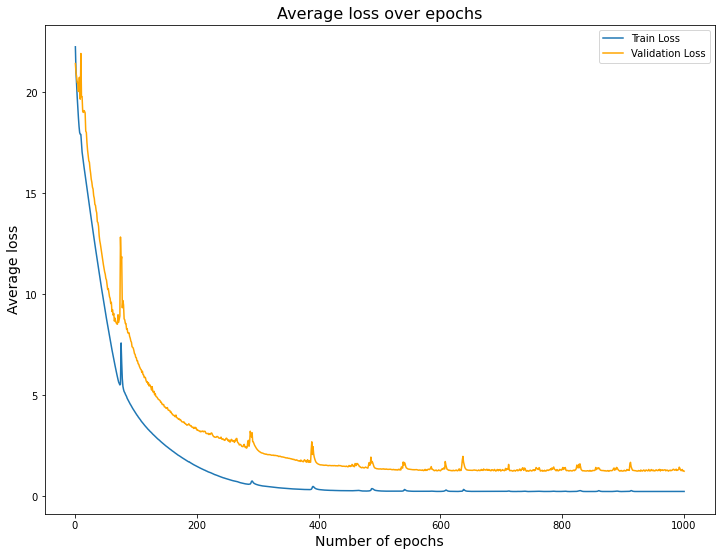

In [12]:
def plot_loss(train_losses, val_losses):
    """
    You may end up plotting the training loss and validation loss multiple times
    It is better to implement a plot function instead of rewriting the plotting steps
    """
    plt.figure(figsize = (12,9))
    plt.plot(range(1,len(train_losses)+1), train_losses)
    plt.plot(range(1,len(val_losses)+1), val_losses, color='orange')
    plt.legend(['Train Loss','Validation Loss'], loc='upper right')
    plt.xlabel('Number of epochs',fontsize=14)
    plt.ylabel('Average loss',fontsize=14)
    plt.title("Average loss over epochs",fontsize=16)
    plt.show()
plot_loss(train_losses, val_losses)


In [13]:

from sklearn.metrics import classification_report

print(classification_report(data_test['class'], val_preds))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65        50
           1       0.86      0.64      0.74        50
           2       0.61      0.74      0.67        50
           3       0.62      0.68      0.65        50
           4       0.76      0.82      0.79        50
           5       0.63      0.52      0.57        50

    accuracy                           0.68       300
   macro avg       0.69      0.68      0.68       300
weighted avg       0.69      0.68      0.68       300

